In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

In [3]:
data = pd.read_csv("Retail and Warehouse Sale.csv")

In [4]:
data.head(10)

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.0,2.0
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.0,4.0
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.0,1.0
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.0,1.0
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.0,0.0
5,2020,1,KYSELA PERE ET FILS LTD,100641,CORTENOVA VENETO P/GRIG - 750ML,WINE,2.76,0.0,6.0
6,2020,1,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.08,1.0,1.0
7,2020,1,BROWN-FORMAN BEVERAGES WORLDWIDE,1008,JACK DANIELS COUNTRY COCKTAIL SOUTHERN PEACH -...,BEER,0.00,0.0,2.0
8,2020,1,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,6.41,4.0,0.0
9,2020,1,INTERNATIONAL CELLARS LLC,101117,KSARA CAB - 750ML,WINE,0.33,1.0,2.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              30000 non-null  int64  
 1   MONTH             30000 non-null  int64  
 2   SUPPLIER          29967 non-null  object 
 3   ITEM CODE         30000 non-null  object 
 4   ITEM DESCRIPTION  30000 non-null  object 
 5   ITEM TYPE         30000 non-null  object 
 6   RETAIL SALES      29999 non-null  float64
 7   RETAIL TRANSFERS  30000 non-null  float64
 8   WAREHOUSE SALES   30000 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.1+ MB


In [6]:
unique_items = data['ITEM DESCRIPTION'].unique()
print(unique_items)

['BOOTLEG RED - 750ML' 'MOMENT DE PLAISIR - 750ML'
 'S SMITH ORGANIC PEAR CIDER - 18.7OZ' ...
 'ANXO NEVERTHELESS WE PERSISTED 1/6 KEG' "E' ARTE PRIMITIVO - 750ML"
 'CINCO SENTIDOS PAPALOMETL MEZCAL - 750ML']


In [7]:
data.describe()

,YEAR,MONTH,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
count,30000.0,30000.000000,29999.000000,30000.000000,30000.000000
mean,2020.0,3.911467,6.939796,6.594058,27.431031
std,0.0,2.836788,33.081054,27.879428,272.166085
min,2020.0,1.000000,-0.420000,-6.000000,-3999.000000
25%,2020.0,1.000000,0.000000,0.000000,0.000000
50%,2020.0,3.000000,0.160000,0.000000,1.000000
75%,2020.0,7.000000,2.920000,3.000000,6.000000
max,2020.0,9.000000,2739.000000,1507.000000,18317.000000


In [8]:
#Number of null values in each column
data.isnull().sum()

YEAR                 0
MONTH                0
SUPPLIER            33
ITEM CODE            0
ITEM DESCRIPTION     0
ITEM TYPE            0
RETAIL SALES         1
RETAIL TRANSFERS     0
WAREHOUSE SALES      0
dtype: int64

In [9]:
#Identifying duplicate rows in the dataset
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [10]:
# Creating a copy of SUPPLIER column
data['SUPPLIER_COPY'] = data['SUPPLIER']

# Performing susbtitutions of missing values in SUPPLIER column
data['SUPPLIER'] = data.groupby(['ITEM CODE', 'ITEM DESCRIPTION'])['SUPPLIER'].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

# Query to display rows where SUPPLIER_COPY was originally NaN
substituted_rows = data[data['SUPPLIER_COPY'].isna()][['SUPPLIER_COPY', 'SUPPLIER', 'ITEM CODE', 'ITEM DESCRIPTION']]
substituted_rows.isnull().sum()

data.drop(columns=['SUPPLIER_COPY'], inplace=True)


In [11]:
#Combining month and year columns into DATETIME column
data['DATE'] = pd.to_datetime(data[['YEAR', 'MONTH']].assign(DAY=1))

In [12]:
#Creating a QUARTER column to indicate seasonal effects
data['QUARTER'] = data['DATE'].dt.quarter

#Creating a Season Map
season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter',
              3: 'Spring', 4: 'Spring', 5: 'Spring',
              6: 'Summer', 7: 'Summer', 8: 'Summer',
              9: 'Fall', 10: 'Fall', 11: 'Fall'}

#Creating SEASON column as a seasonal indicator
data['SEASON'] = data['MONTH'].map(season_map)

In [13]:
#Creating RETAIL_SALES_ROLLING_3M (3-month rolling average) for RETAIL SALES to smoothen random short-term fluctuations
data['RETAIL_SALES_ROLLING_3M'] = data['RETAIL SALES'].rolling(window=3).mean()

#Creating RETAIL_SALES_ROLLING_STD_3M (3-month rolling standard deviation) for RETAIL SALES to understand volatility
data['RETAIL_SALES_ROLLING_STD_3M'] = data['RETAIL SALES'].rolling(window=3).std()

In [14]:
#Creating WAREHOUSE_SALES_ROLLING_3M (3-month rolling average) for WAREHOUSE SALES to smoothen random short-term fluctuations
data['WAREHOUSE_SALES_ROLLING_3M'] = data['WAREHOUSE SALES'].rolling(window=3).mean()

#Creating RETAIL_SALES_ROLLING_STD_3M (3-month rolling standard deviation) for RETAIL SALES to understand volatility
data['WAREHOUSE_SALES_ROLLING_STD_3M'] = data['WAREHOUSE SALES'].rolling(window=3).std()


In [15]:
#Creating RETAIL_TRANSFERS_ROLLING_3M (3-month rolling average) to smoothen random short-term fluctuations
data['RETAIL_TRANSFERS_ROLLING_3M'] = data['RETAIL TRANSFERS'].rolling(window=3).std()

#Creating RETAIL_TRANSFERS_ROLLING_STD_3M (3-month rolling standard deviation) for RETAIL TRANSFERS to understand volatility
data['RETAIL_TRANSFERS_ROLLING_STD_3M'] = data['RETAIL TRANSFERS'].rolling(window=3).std()

In [16]:
#Creating lagged sales variables to identify dependencies between prior sales and current sales.
data['RETAIL_SALES_LAG_1'] = data['RETAIL SALES'].shift(1)

data['WAREHOUSE_SALES_LAG_1'] = data['WAREHOUSE SALES'].shift(1)

data['RETAIL_TRANSFERS_LAG_1'] = data['RETAIL TRANSFERS'].shift(1)

In [17]:
columns_to_backfill = ['RETAIL_SALES_LAG_1', 'RETAIL_SALES_ROLLING_3M', 'WAREHOUSE_SALES_ROLLING_3M', 'RETAIL_SALES_ROLLING_STD_3M','WAREHOUSE_SALES_ROLLING_STD_3M', 'RETAIL_SALES_LAG_1', 'WAREHOUSE_SALES_LAG_1','RETAIL_TRANSFERS_LAG_1']

data[columns_to_backfill] = data[columns_to_backfill].bfill()

missing_values_after_fill = data[columns_to_backfill].isnull().sum()
print(missing_values_after_fill)

RETAIL_SALES_LAG_1                0
RETAIL_SALES_ROLLING_3M           0
WAREHOUSE_SALES_ROLLING_3M        0
RETAIL_SALES_ROLLING_STD_3M       0
WAREHOUSE_SALES_ROLLING_STD_3M    0
RETAIL_SALES_LAG_1                0
WAREHOUSE_SALES_LAG_1             0
RETAIL_TRANSFERS_LAG_1            0
dtype: int64


In [18]:
data.head(10)

data.fillna(0, inplace=True)

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   YEAR                             30000 non-null  int64         
 1   MONTH                            30000 non-null  int64         
 2   SUPPLIER                         30000 non-null  object        
 3   ITEM CODE                        30000 non-null  object        
 4   ITEM DESCRIPTION                 30000 non-null  object        
 5   ITEM TYPE                        30000 non-null  object        
 6   RETAIL SALES                     30000 non-null  float64       
 7   RETAIL TRANSFERS                 30000 non-null  float64       
 8   WAREHOUSE SALES                  30000 non-null  float64       
 9   DATE                             30000 non-null  datetime64[ns]
 10  QUARTER                          30000 non-null  int64    

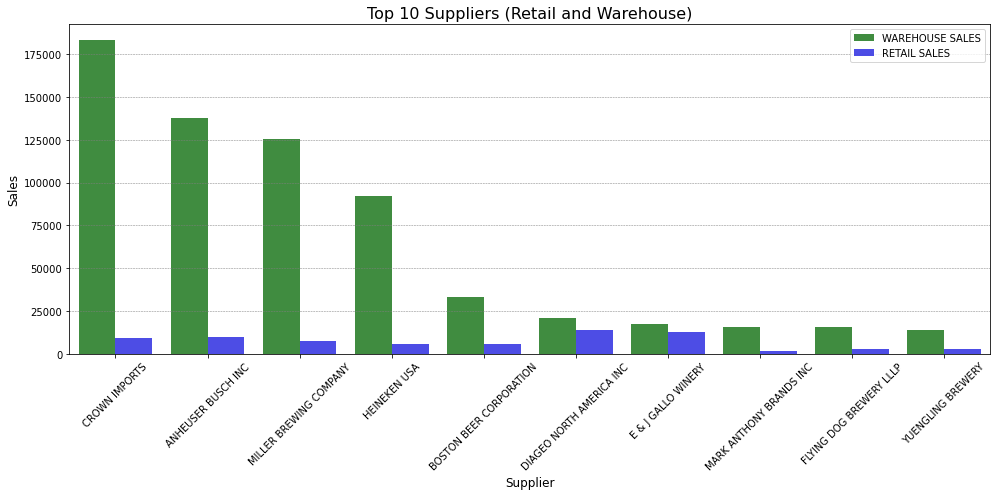

In [19]:
# Group by SUPPLIER and sum WAREHOUSE SALES and RETAIL SALES
supplier_sales = data.groupby('SUPPLIER')[['WAREHOUSE SALES', 'RETAIL SALES']].sum().reset_index()

# Sort first by WAREHOUSE SALES (descending), then by RETAIL SALES (descending)
sorted_supplier_sales = supplier_sales.sort_values(by=['WAREHOUSE SALES', 'RETAIL SALES'], ascending=[False, False])

# Select the top 10 suppliers
top_10_suppliers = sorted_supplier_sales.head(10)

# Melt data for visualization
melted_data = top_10_suppliers.melt(
    id_vars='SUPPLIER', 
    var_name='Sales Type', 
    value_name='Sales'
)

# Plotting the bar chart
plt.figure(figsize=(14, 7))
sns.barplot(
    x='SUPPLIER', 
    y='Sales', 
    hue='Sales Type', 
    data=melted_data, 
    palette=['green', 'blue'], 
    alpha=0.8
)
plt.tick_params(axis='x', labelrotation=45)
plt.title('Top 10 Suppliers (Retail and Warehouse)', fontsize=16)
plt.ylabel('Sales', fontsize=12)
plt.xlabel('Supplier', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()


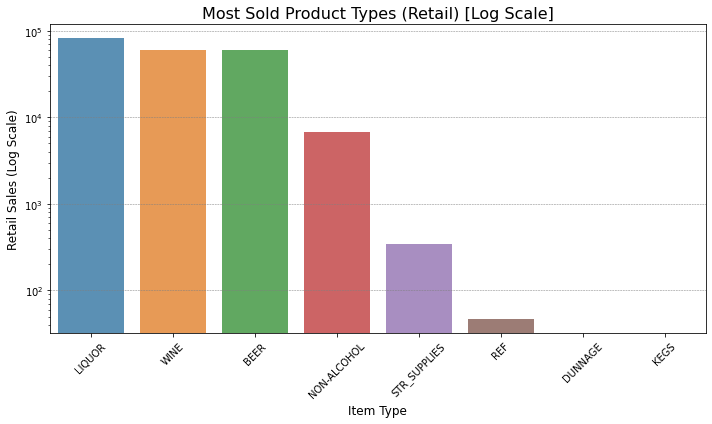

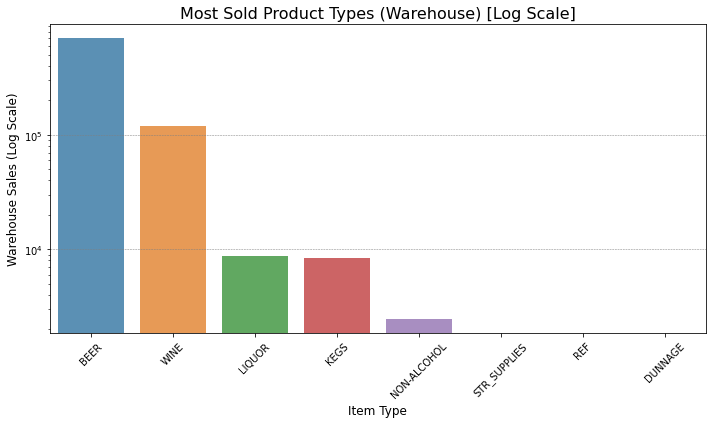

In [20]:
sales_by_type = data.groupby('ITEM TYPE')[['RETAIL SALES', 'WAREHOUSE SALES']].sum().reset_index()

sales_by_type_retail = sales_by_type.sort_values('RETAIL SALES', ascending=False)
sales_by_type_warehouse = sales_by_type.sort_values('WAREHOUSE SALES', ascending=False)

# Plotting Retail Sales with Log Scale
plt.figure(figsize=(10, 6))
sns.barplot(
    x='ITEM TYPE',
    y='RETAIL SALES',
    data=sales_by_type_retail,
    alpha=0.8
)
plt.yscale('log')  # Apply logarithmic scale to the y-axis
plt.title('Most Sold Product Types (Retail) [Log Scale]', fontsize=16)
plt.xlabel('Item Type', fontsize=12)
plt.ylabel('Retail Sales (Log Scale)', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

# Plotting Warehouse Sales with Log Scale
plt.figure(figsize=(10, 6))
sns.barplot(
    x='ITEM TYPE',
    y='WAREHOUSE SALES',
    data=sales_by_type_warehouse,
    alpha=0.8
)
plt.yscale('log')  # Apply logarithmic scale to the y-axis
plt.title('Most Sold Product Types (Warehouse) [Log Scale]', fontsize=16)
plt.xlabel('Item Type', fontsize=12)
plt.ylabel('Warehouse Sales (Log Scale)', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

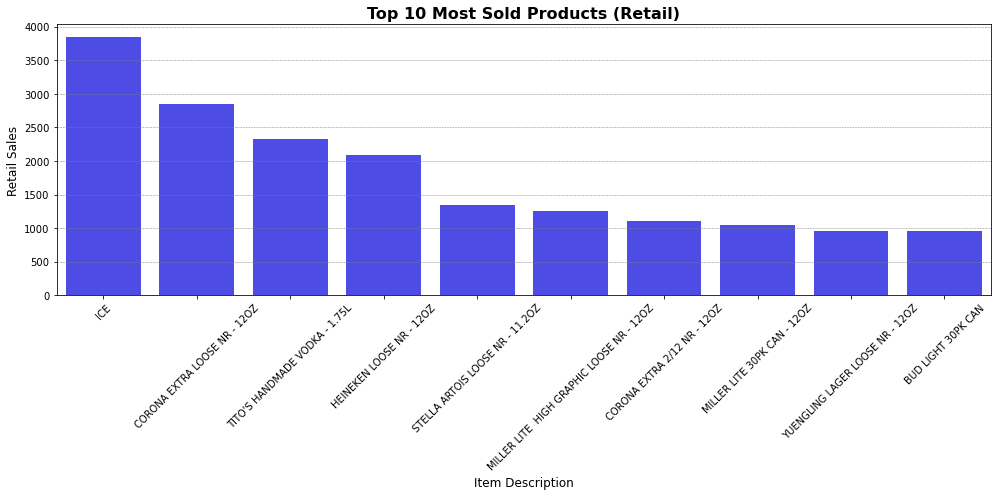

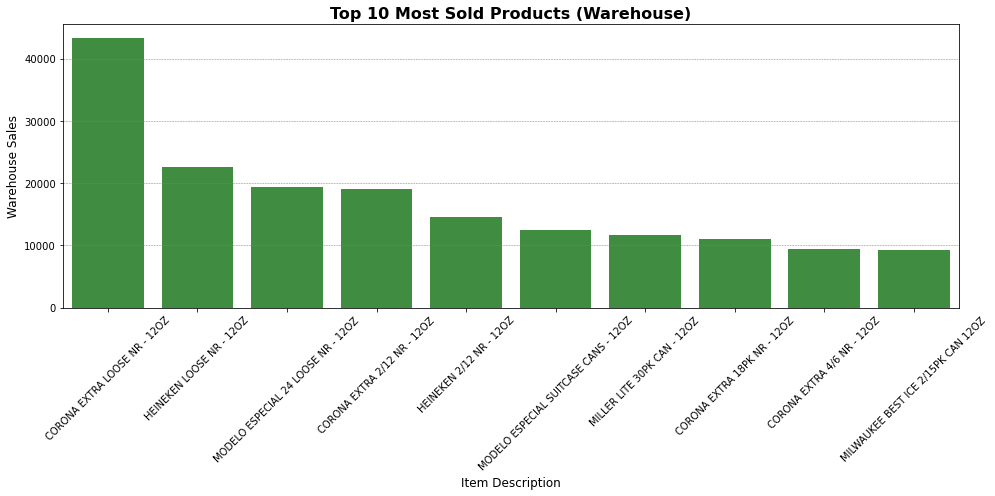

In [21]:
# Grouping by ITEM CODE and ITEM DESCRIPTION, summing sales for Retail and Warehouse
sales_by_item_description = data.groupby('ITEM DESCRIPTION')[['RETAIL SALES', 'WAREHOUSE SALES']].sum().reset_index()


# Sorting by sales in descending order and selecting the top 10 most sold products
most_sold_retail_product = sales_by_item_description.sort_values('RETAIL SALES', ascending=False).head(10)
most_sold_warehouse_product = sales_by_item_description.sort_values('WAREHOUSE SALES', ascending=False).head(10)

# Plotting Retail Sales (Top 10 Products)
plt.figure(figsize=(14, 7))
sns.barplot(
    x='ITEM DESCRIPTION', 
    y='RETAIL SALES',  
    data=most_sold_retail_product, 
    alpha=0.8,
    color='blue'  # Optional: Set a consistent color for visual appeal
)
plt.tick_params(axis='x', labelrotation=45)
plt.title('Top 10 Most Sold Products (Retail)', fontsize=16, fontweight='bold')
plt.ylabel('Retail Sales', fontsize=12)
plt.xlabel('Item Description', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()
plt.show()  # Ensure the plot is displayed

# Plotting Warehouse Sales (Top 10 Products)
plt.figure(figsize=(14, 7))
sns.barplot(
    x='ITEM DESCRIPTION', 
    y='WAREHOUSE SALES',  
    data=most_sold_warehouse_product, 
    alpha=0.8,
    color='green'  # Optional: Set a consistent color for visual appeal
)
plt.tick_params(axis='x', labelrotation=45)
plt.title('Top 10 Most Sold Products (Warehouse)', fontsize=16, fontweight='bold')
plt.ylabel('Warehouse Sales', fontsize=12)
plt.xlabel('Item Description', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()
plt.show()  # Ensure the plot is displayed


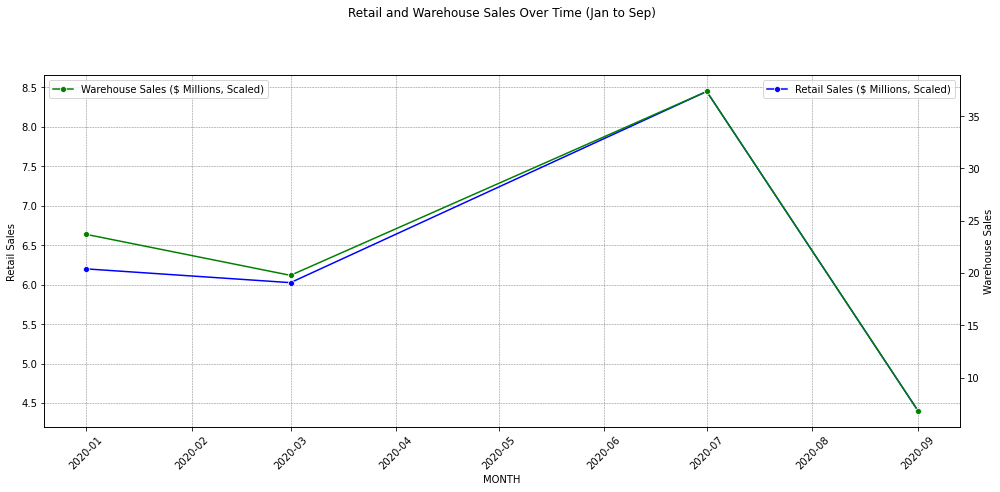

In [22]:
fig, ax1 = plt.subplots(figsize=(14, 7))


sns.lineplot(ax=ax1, x='DATE', y='RETAIL SALES', data=data, label='Retail Sales ($ Millions, Scaled)', marker="o", ci=None, color='blue')
ax1.set_xlabel('MONTH')
ax1.set_ylabel('Retail Sales')
ax1.xaxis.set_label_position('bottom')
ax1.tick_params(axis='x', labelrotation=45) 
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')


ax2 = ax1.twinx()
sns.lineplot(ax=ax2, x='DATE', y='WAREHOUSE SALES', data=data, label='Warehouse Sales ($ Millions, Scaled)', marker="o", ci=None, color='green')
ax2.set_xlabel('MONTH')
ax2.set_ylabel('Warehouse Sales')
ax2.xaxis.set_label_position('top')
ax2.tick_params(axis='x', labelrotation=45)


plt.title('Retail and Warehouse Sales Over Time (Jan to Sep)', y=1.15)
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.tight_layout()

plt.show()


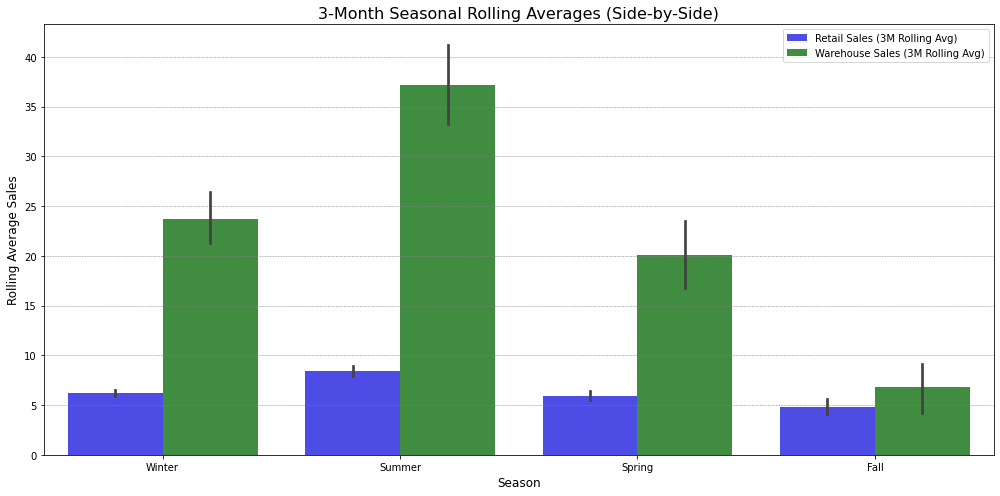

In [23]:
melted_data = data[['SEASON', 'RETAIL_SALES_ROLLING_3M', 'WAREHOUSE_SALES_ROLLING_3M']].melt(
    id_vars='SEASON', 
    var_name='Sales Type', 
    value_name='Rolling Average Sales'
)

melted_data['Sales Type'] = melted_data['Sales Type'].replace({
    'RETAIL_SALES_ROLLING_3M': 'Retail Sales (3M Rolling Avg)',
    'WAREHOUSE_SALES_ROLLING_3M': 'Warehouse Sales (3M Rolling Avg)'
})

plt.figure(figsize=(14, 7))
sns.barplot(
    x='SEASON', 
    y='Rolling Average Sales', 
    hue='Sales Type', 
    data=melted_data, 
    palette=['blue', 'green'], 
    alpha=0.8
)


plt.title('3-Month Seasonal Rolling Averages (Side-by-Side)', fontsize=16)
plt.ylabel('Rolling Average Sales', fontsize=12)
plt.xlabel('Season', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()


In [24]:
seasonal_summary = data.groupby('SEASON')[['RETAIL SALES', 'WAREHOUSE SALES']].sum()
seasonal_summary['SALES_DIFFERENCE'] = seasonal_summary['RETAIL SALES'] - seasonal_summary['WAREHOUSE SALES']
print(seasonal_summary)


        RETAIL SALES  WAREHOUSE SALES  SALES_DIFFERENCE
SEASON                                                 
Fall         4805.31          7416.57          -2611.26
Spring      34523.90        113305.22         -78781.32
Summer      94538.96        418094.42        -323555.46
Winter      74318.77        284114.72        -209795.95


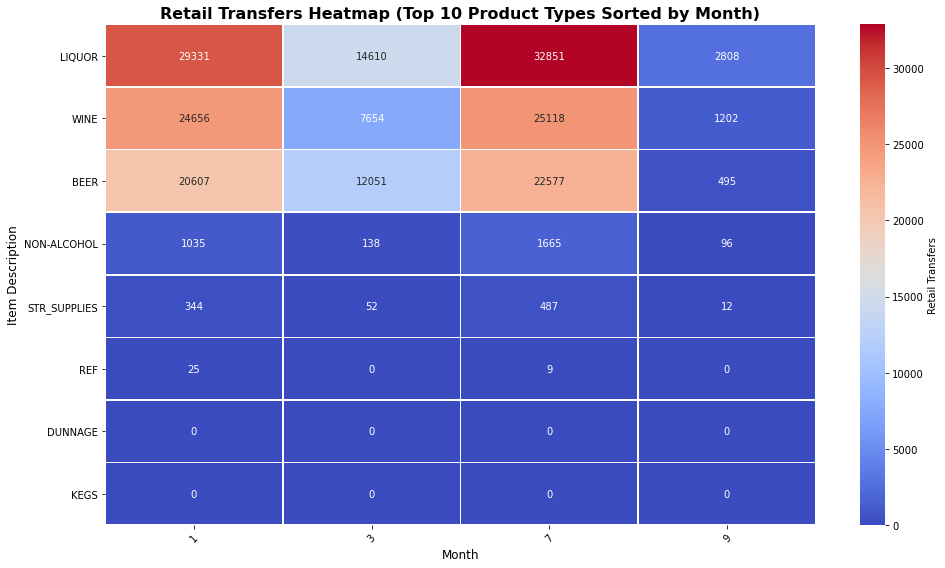

In [25]:
#Heatmap for top 10 retail transferred product types (aggregated)
top_items = (
    data.groupby('ITEM TYPE')['RETAIL TRANSFERS']
    .sum()
    .sort_values(ascending=False)
    .index
)

# Filter data for these top item types
heatmap_data_filtered = data[data['ITEM TYPE'].isin(top_items)]

# Group and pivot for heatmap
heatmap_data_pivot = (
    heatmap_data_filtered.groupby(['ITEM TYPE', 'MONTH'])['RETAIL TRANSFERS']
    .sum()
    .reset_index()
    .pivot(index='ITEM TYPE', columns='MONTH', values='RETAIL TRANSFERS')
    .fillna(0)  # Fill missing values with 0
)
#heatmap_data_pivot = heatmap_data_pivot[season_order]

# Add a 'Total Transfers' column to sort items
heatmap_data_pivot['Total Transfers'] = heatmap_data_pivot.sum(axis=1)

# Sort items by 'Total Transfers'
heatmap_data_pivot = heatmap_data_pivot.sort_values('Total Transfers', ascending=False)

# Drop the 'Total Transfers' column after sorting (optional for visualization)
heatmap_data_pivot = heatmap_data_pivot.drop(columns=['Total Transfers'])

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data_pivot,
    cmap='coolwarm',
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    cbar_kws={'label': 'Retail Transfers'},
)
plt.title('Retail Transfers Heatmap (Top 10 Product Types Sorted by Month)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Item Description', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [27]:
# Preprocessing
# Group by item type and month, sum sales for historical data
data_grouped = data.groupby(['ITEM TYPE', 'MONTH']).agg({'RETAIL SALES': 'sum'}).reset_index()

# Encode categorical variables
le = LabelEncoder()
data_grouped['ITEM TYPE ENCODED'] = le.fit_transform(data_grouped['ITEM TYPE'])

# Prepare data for modeling
# Using months other than 10, 11, 12 for training
train_data = data_grouped[~data_grouped['MONTH'].isin([10, 11, 12])]

# Features and target variable
X_train = train_data[['ITEM TYPE ENCODED', 'MONTH']]
y_train = train_data['RETAIL SALES']

# Define the months for prediction
prediction_months = pd.DataFrame({
    'ITEM TYPE ENCODED': np.repeat(train_data['ITEM TYPE ENCODED'].unique(), 3),
    'MONTH': [10, 11, 12] * len(train_data['ITEM TYPE ENCODED'].unique())
})

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions for the specified months
predicted_sales = xgb_model.predict(prediction_months)

# Combine predictions with item type and months
prediction_results = prediction_months.copy()
prediction_results['PREDICTED SALES'] = predicted_sales

# Decode item type
prediction_results['ITEM TYPE'] = le.inverse_transform(prediction_results['ITEM TYPE ENCODED'])

# Save predictions to a new CSV file
predicted_sales = prediction_results[['ITEM TYPE', 'MONTH', 'PREDICTED SALES']]

print(predicted_sales)

       ITEM TYPE  MONTH  PREDICTED SALES
0           BEER     10       661.560425
1           BEER     11       661.560425
2           BEER     12       661.560425
3        DUNNAGE     10         1.943618
4        DUNNAGE     11         1.943618
5        DUNNAGE     12         1.943618
6           KEGS     10         1.943618
7           KEGS     11         1.943618
8           KEGS     12         1.943618
9         LIQUOR     10      2774.762451
10        LIQUOR     11      2774.762451
11        LIQUOR     12      2774.762451
12   NON-ALCOHOL     10       143.204361
13   NON-ALCOHOL     11       143.204361
14   NON-ALCOHOL     12       143.204361
15           REF     10        32.318798
16           REF     11        32.318798
17           REF     12        32.318798
18  STR_SUPPLIES     10        32.318798
19  STR_SUPPLIES     11        32.318798
20  STR_SUPPLIES     12        32.318798
21          WINE     10      1309.265137
22          WINE     11      1309.265137
23          WINE

In [30]:
# Encode categorical variables
data_grouped = data.groupby(['ITEM TYPE', 'MONTH']).agg({'WAREHOUSE SALES': 'sum'}).reset_index()

le = LabelEncoder()
data_grouped['ITEM TYPE ENCODED'] = le.fit_transform(data_grouped['ITEM TYPE'])

# Prepare data for modeling
# Using months other than 10, 11, 12 for training
train_data = data_grouped[~data_grouped['MONTH'].isin([10, 11, 12])]

# Features and target variable
X_train = train_data[['ITEM TYPE ENCODED', 'MONTH']]
y_train = train_data['WAREHOUSE SALES']

# Define the months for prediction
prediction_months = pd.DataFrame({
    'ITEM TYPE ENCODED': np.repeat(train_data['ITEM TYPE ENCODED'].unique(), 3),
    'MONTH': [10, 11, 12] * len(train_data['ITEM TYPE ENCODED'].unique())
})

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions for the specified months
predicted_sales = xgb_model.predict(prediction_months)

# Combine predictions with item type and months
prediction_results = prediction_months.copy()
prediction_results['PREDICTED SALES'] = predicted_sales

# Decode item type
prediction_results['ITEM TYPE'] = le.inverse_transform(prediction_results['ITEM TYPE ENCODED'])

# Save predictions to a new CSV file
predicted_warehouse_sales = prediction_results[['ITEM TYPE', 'MONTH', 'PREDICTED SALES']]

print(predicted_warehouse_sales)

       ITEM TYPE  MONTH  PREDICTED SALES
0           BEER     10      5501.566895
1           BEER     11      5501.566895
2           BEER     12      5501.566895
3        DUNNAGE     10     -1867.729370
4        DUNNAGE     11     -1867.729370
5        DUNNAGE     12     -1867.729370
6           KEGS     10       292.313507
7           KEGS     11       292.313507
8           KEGS     12       292.313507
9         LIQUOR     10       364.311035
10        LIQUOR     11       364.311035
11        LIQUOR     12       364.311035
12   NON-ALCOHOL     10        10.739015
13   NON-ALCOHOL     11        10.739015
14   NON-ALCOHOL     12        10.739015
15           REF     10       -66.935905
16           REF     11       -66.935905
17           REF     12       -66.935905
18  STR_SUPPLIES     10         5.093291
19  STR_SUPPLIES     11         5.093291
20  STR_SUPPLIES     12         5.093291
21          WINE     10      3432.003418
22          WINE     11      3432.003418
23          WINE